
# GPR for Hydrochar Carbon Mass

This notebook runs a **Gaussian Process Regression (GPR)** model to predict **Hydrochar carbon mass (g)**
from hydrothermal carbonization (HTC) experiment parameters using your file **`sample_htc_data.xlsx`**
(sheet: **Hydrothermal carbonization**). It mirrors your script but is structured for Jupyter.

**Pipeline:**
1. Imports & setup  
2. Load data  
3. Preprocess (clean, scale, split)  
4. Build/Train GPR (RBF or Matern)  
5. Evaluate & plot  
6. Optional: Repeat runs and save metrics  
7. Best-run correlation heatmap  
8. SHAP feature importance


In [2]:

# Step 1 — Imports & setup
import os, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

# Optional: !pip install seaborn shap
import seaborn as sns
import shap

plt.rcParams["font.sans-serif"] = ["Times New Roman"]

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\check\OneDrive - Kentucky State University\Python Learning


In [3]:

# Step 2 — Load data
def get_data(file_path, sheet_name="Hydrothermal carbonization"):
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    data = data.replace([np.nan], 0)
    return data

data_path = "sample_htc_data.xlsx"  # change if needed
data = get_data(data_path)
print("Rows, columns:", data.shape)
display(data.head(10))


Rows, columns: (292, 17)


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Hydrochar carbon mass g,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,0.0,20.0,50.0,0.066407,0.0,0.0,30.336667,0.0,0.0,Two-step hydrothermal conversion of biomass wa...
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,1.0,20.0,50.0,0.066239,0.0,0.0,30.260000,0.0,0.0,0
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4.0,1.0,20.0,50.0,0.091726,0.0,0.0,41.903333,0.0,0.0,0
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4.0,1.0,20.0,50.0,0.067498,0.0,0.0,30.835000,0.0,0.0,0
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.022480,0.0,0.0,11.240000,0.0,0.0,Hydrothermal humification of lignocellulosic c...
5,Hemicellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.026528,0.0,0.0,13.264000,0.0,0.0,0
6,Cellulose+hemicellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.042844,0.0,0.0,21.422222,0.0,0.0,0
7,Cellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.009910,0.0,0.0,4.955000,0.0,0.0,0
8,Hemicellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.019300,0.0,0.0,9.650000,0.0,0.0,0
9,Cellulose+hemicellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.015000,0.0,0.0,7.500000,0.0,0.0,0


In [4]:

# Step 3 — Preprocess
def preprocess_data(data):
    col_cond = [
        "mass g","Vessel volume ml","Carbon content %","Hydrogen content %",
        "Oxygen content %","Reaction temperature","Hold time h","pH","Liquid-to-solid ratio",
    ]
    col_res = ["Hydrochar carbon mass g"]

    for col in col_cond + col_res:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")
        data[col] = pd.to_numeric(data[col], errors="coerce")

    data = data.replace([np.inf, -np.inf], np.nan)
    if data.isnull().any().any():
        print("Found missing values; imputing with column medians.")
        data = data.fillna(data.median(numeric_only=True))

    original_data = data.copy()

    scaler = StandardScaler()
    data[col_cond] = scaler.fit_transform(data[col_cond])

    X = data[col_cond].values
    y = data[col_res].values.flatten()

    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, data.index, test_size=0.2, random_state=None
    )
    return X_train, X_test, y_train, y_test, train_idx, test_idx, data[col_cond].columns, original_data, scaler

X_train, X_test, y_train, y_test, train_idx, test_idx, feature_names, original_data, scaler = preprocess_data(data)
print("Train size:", len(X_train), "Test size:", len(X_test))
feature_names


Train size: 233 Test size: 59


Index(['mass g', 'Vessel volume ml', 'Carbon content %', 'Hydrogen content %',
       'Oxygen content %', 'Reaction temperature', 'Hold time h', 'pH',
       'Liquid-to-solid ratio'],
      dtype='object')

In [5]:

# Step 4 — Build GPR
def build_model(kernel_type='RBF', length_scale=5.0, noise_level=5.0, n_restarts_optimizer=10):
    if kernel_type == 'RBF':
        kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    elif kernel_type == 'Matern':
        kernel = Matern(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    else:
        raise ValueError("Unsupported kernel type. Choose 'RBF' or 'Matern'.")
    return GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, random_state=30)

kernel_type = 'RBF'
length_scale = 5.0
noise_level = 5.0
n_restarts_optimizer = 5

gpr = build_model(kernel_type, length_scale, noise_level, n_restarts_optimizer)
gpr


GaussianProcessRegressor(kernel=RBF(length_scale=5) + WhiteKernel(noise_level=5),
                         n_restarts_optimizer=5, random_state=30)

In [6]:

# Step 5 — Train & Evaluate
gpr.fit(X_train, y_train)
y_pred = gpr.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print(f"MAE:  {MAE:.4f}")
print(f"MSE:  {MSE:.4f}")
print(f"RMSE: {RMSE:.4f}")
print(f"R^2:  {R2:.4f}")


MAE:  1.1919
MSE:  4.0334
RMSE: 2.0083
R^2:  0.7368


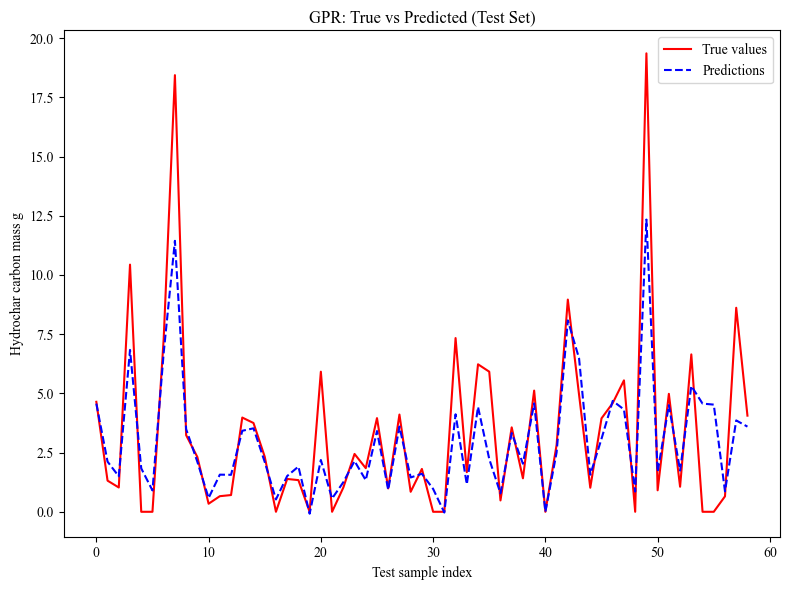

In [7]:

# Step 6 — Plot True vs Predicted
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(y_test)), y_test, "r-", label="True values")
plt.plot(np.arange(len(y_pred)), y_pred, "b--", label="Predictions")
plt.legend()
plt.xlabel("Test sample index")
plt.ylabel("Hydrochar carbon mass g")
plt.title("GPR: True vs Predicted (Test Set)")
plt.tight_layout()
plt.show()


In [8]:

# Step 7 — Optional: Repeat runs (n_runs) and save metrics to Excel
n_runs = 10
metrics = []
best_r2 = -np.inf
best_pack = None

for i in range(n_runs):
    X_train_i, X_test_i, y_train_i, y_test_i, train_idx_i, test_idx_i, fn_i, od_i, sc_i = preprocess_data(data)
    model_i = build_model(kernel_type, length_scale, noise_level, n_restarts_optimizer)
    model_i.fit(X_train_i, y_train_i)
    y_pred_i = model_i.predict(X_test_i)

    mae_i = mean_absolute_error(y_test_i, y_pred_i)
    mse_i = mean_squared_error(y_test_i, y_pred_i)
    rmse_i = np.sqrt(mse_i)
    r2_i = r2_score(y_test_i, y_pred_i)

    metrics.append([i+1, mae_i, mse_i, rmse_i, r2_i])
    if r2_i > best_r2:
        best_r2 = r2_i
        best_pack = (i+1, train_idx_i, test_idx_i, fn_i, model_i, od_i, sc_i, X_train_i, X_test_i)

metrics_df = pd.DataFrame(metrics, columns=["Iter", "MAE", "MSE", "RMSE", "R2"])
now = datetime.datetime.now().strftime("%Y%m%d%H%M")
result_file = f"gpr_results_{now}.xlsx"
metrics_df.to_excel(result_file, index=False)
print("Saved metrics to:", os.path.abspath(result_file))

display(metrics_df.describe())


Saved metrics to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\gpr_results_202511100006.xlsx


,Iter,MAE,MSE,RMSE,R2
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,1.323610,6.445261,2.456778,0.717852
std,3.02765,0.285936,3.434328,0.674540,0.057041
min,1.00000,0.949807,2.443607,1.563204,0.608719
25%,3.25000,1.081182,3.599866,1.896431,0.679099
50%,5.50000,1.314422,6.992091,2.644255,0.722214
75%,7.75000,1.562131,7.540485,2.745618,0.760470
max,10.00000,1.736419,13.448519,3.667222,0.785481


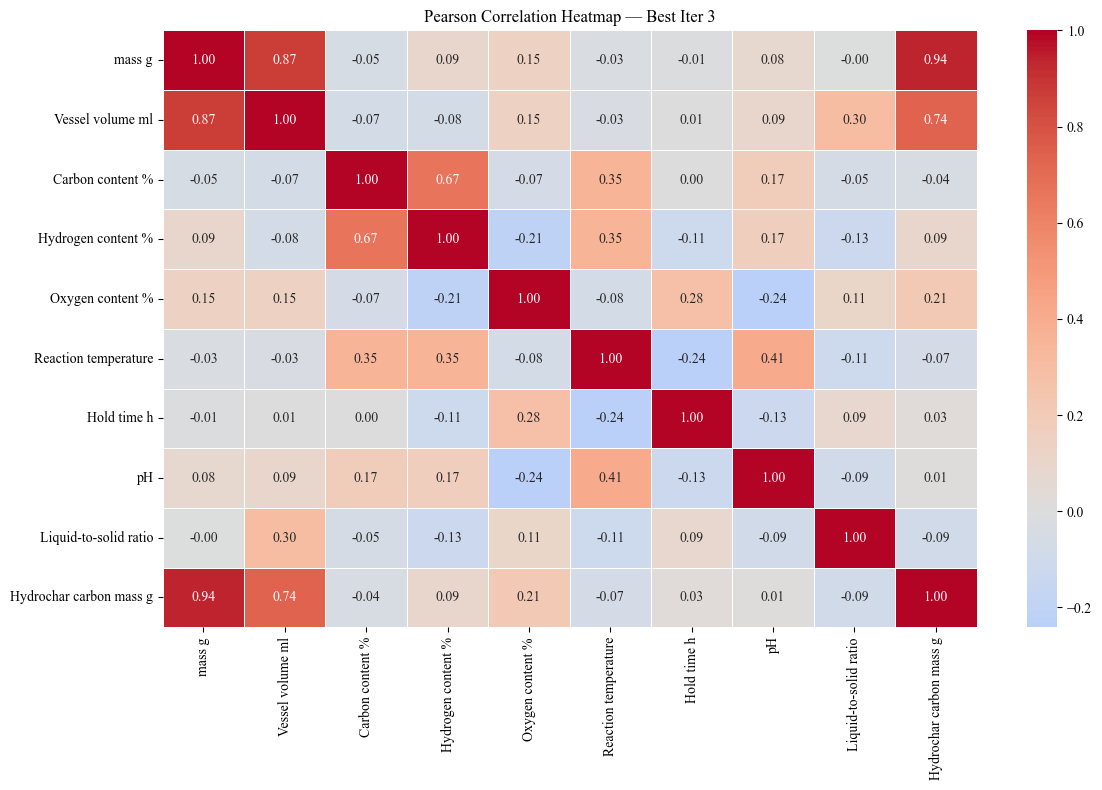

In [9]:

# Step 8 — Correlation heatmap (best run)
best_i, best_train_idx, best_test_idx, best_feature_names, best_model, best_original_data, best_scaler, best_X_train, best_X_test = best_pack

test_df = best_original_data.loc[best_test_idx].copy()
test_df["Predicted Hydrochar carbon mass g"] = best_model.predict(
    best_scaler.transform(test_df[best_feature_names])
)

corr_cols = best_feature_names.tolist() + ["Hydrochar carbon mass g"]
corr = test_df[corr_cols].corr(method='pearson')

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title(f"Pearson Correlation Heatmap — Best Iter {best_i}")
plt.tight_layout()
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

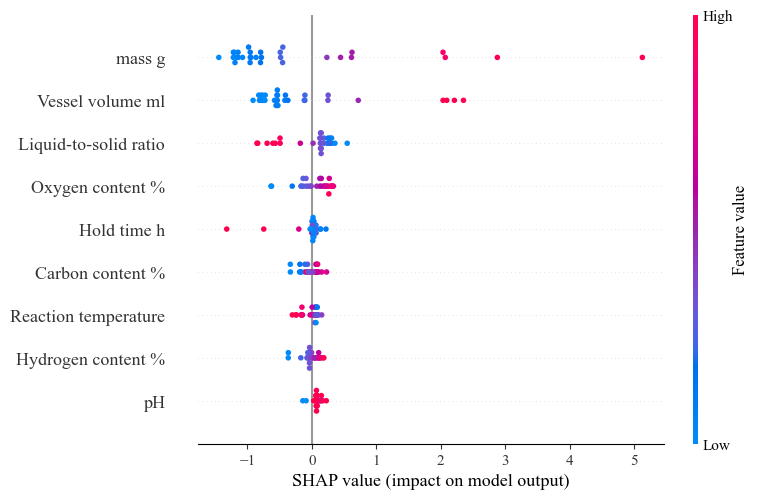

In [10]:

# Step 9 — SHAP feature importance (KernelExplainer with small background for speed)
try:
    X_background = best_X_train[:40] if best_X_train.shape[0] > 40 else best_X_train
    X_explain = best_X_test[:30] if best_X_test.shape[0] > 30 else best_X_test

    explainer = shap.KernelExplainer(best_model.predict, X_background)
    shap_values = explainer.shap_values(X_explain)

    shap.summary_plot(shap_values, X_explain, feature_names=best_feature_names)
except Exception as e:
    print("SHAP skipped due to:", e)
